In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host="localhost",
                             username ="root",
                             password ="Vivek@123",
                             database = "ecommerce"
)
cur = db.cursor()


# List all unique cities where customers are located.

In [29]:
query = """Select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query = """Select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"TOtal order placed in 2017", data[0][0]

('TOtal order placed in 2017', 45101)

# Find the total Sales per category.

In [4]:
query = """Select products.productcategory category,
round(sum(payments.payment_value),2) Sales
From products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
Group by products.productcategory;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['category','Sales'])
df

,category,Sales
0,perfumery,1013477.32
1,Furniture Decoration,2860352.78
2,telephony,973764.10
3,bed table bath,3425107.34
4,automotive,1704588.66
...,...,...
69,cds music dvds,2398.86
70,La Cuisine,5827.06
71,Fashion Children's Clothing,1571.34
72,PC Gamer,4348.86


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ Select (
sum(Case when payment_installments > 1
	then 1 
	else 0 
 end))/ count(*)*100
 from payments;
"""
cur.execute(query)
data = cur.fetchall()
"The Percentage of Orders that were paid in installments is" ,data[0][0]

('The Percentage of Orders that were paid in installments is',
 Decimal('49.4176'))

# Count the number of customers from each state.

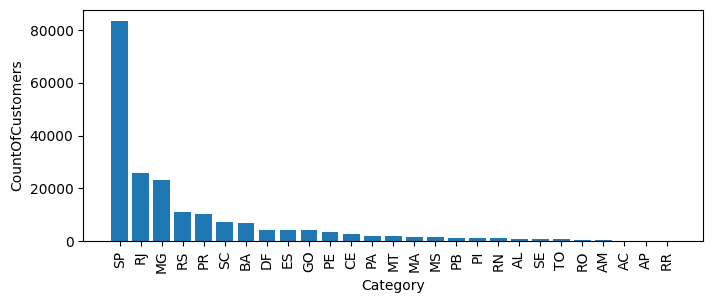

In [6]:
query = """ Select customer_state ,
count(customer_id) 
from ecommerce.customers
group by customer_state"""

cur.execute(query)
data = cur.fetchall()
plt.figure(figsize = (8,3))
df = pd.DataFrame(data, columns = ['state','countofcustomers'])
df = df.sort_values(by = "countofcustomers", ascending = False)
plt.bar(df['state'],df['countofcustomers'])
plt.xticks(rotation = 90)
plt.xlabel("Category")
plt.ylabel("CountOfCustomers")
plt.show()

# Calculate the number of orders per month in 2018.

In [7]:
import calendar

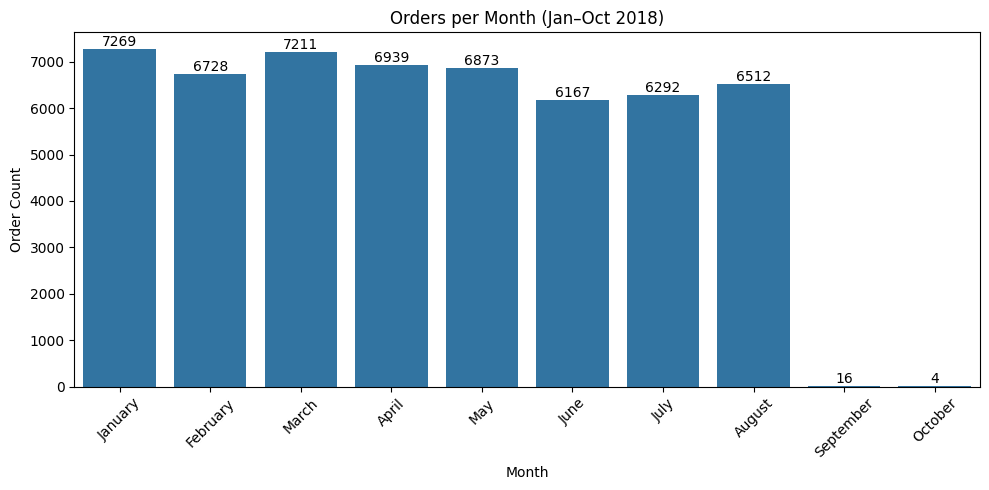

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# SQL query
query = """
SELECT MONTH(order_purchase_timestamp) AS months, 
       COUNT(order_id) AS order_count
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Filter for January (1) to October (10)
df = df[df["months"] <= 10]

# Convert month numbers to names
df["month_name"] = df["months"].apply(lambda x: calendar.month_name[x])

# Define custom order: Jan to Oct only
month_order = list(calendar.month_name)[1:11]  # Jan to Oct

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="month_name", y="order_count", data=df, order=month_order)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title("Orders per Month (Jan–Oct 2018)")
plt.xlabel("Month")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_per_order as
(
Select orders.order_id,
orders.customer_id,
count(order_items.order_item_id) as oc
From orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id
)
Select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
From customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","avg_orders"])
df                  

,customer_city,avg_orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
...,...,...
4105,tuiuti,2.00
4106,aurora do para,2.00
4107,nova america,2.00
4108,tibau do sul,2.00


# calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """ Select products.productcategory,
round((sum(payments.payment_value)/ (Select sum(payments.payment_value) from payments))*100,2) Sales_Percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by products.productcategory order by Sales_Percentage DESC;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Percentage distribution"])
df.head()

,Category,Percentage distribution
0,bed table bath,21.40
1,HEALTH BEAUTY,20.71
2,computer accessories,19.81
3,Furniture Decoration,17.87
4,Watches present,17.86


## Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
import numpy as np
print(np.__version__)

2.3.1


In [12]:
query = """Select products.productcategory,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.productcategory;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","count_products","avg_price"])
arr1 = df["count_products"]
arr2 = df["avg_price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is " , a[0][1])

The correlation between product price and the number of times a product has been purchased is  -0.10631514167157557


# Calculate total revenue generated by each seller and rank them by revenue.

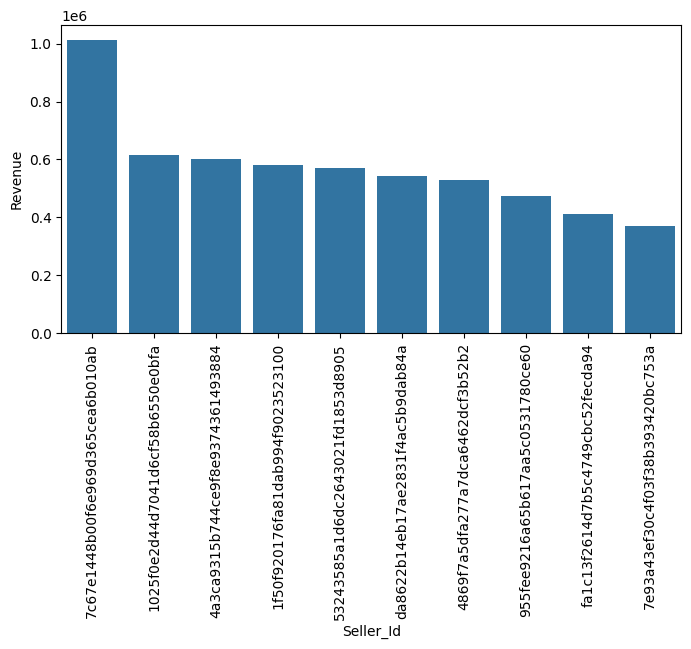

In [13]:
query = """Select seller_id,
revenue,
dense_rank() over(order by revenue DESC) rank_seller
from
(
Select order_items.seller_id,
round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id
)t"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_Id","Revenue","Seller_Rank"])
df = df.head(10)
plt.figure(figsize = (8,4))
ax = sns.barplot(x = "Seller_Id", y = "Revenue", data  = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """Select customer_id,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row ) as mov_avg
from(
Select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from orders join payments
on orders.order_id = payments.order_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["ID", "Timestamp", "Moving_avg"])
df.head()

,ID,Timestamp,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


# Culculate the cumulative sales per month for each year.

In [20]:
query = """Select years, months,
sum(payment) over(order by years,months ) as cumulative_payment from
(
Select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month", "Cum_Sales"])
df.head()

,Year,Month,Cum_Sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39


# Calculate the year - orver - year growth rate the sales.

In [21]:
query = """with a as (Select year(orders.order_purchase_timestamp) as years,
sum(payments.payment_value) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

Select years, ((payment -lag(payment,1) over(order by years))/ (lag(payment,1) over(order by years)))*100 
as previous_year from a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "previous_year"])
df

,Years,previous_year
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [23]:
query = """with a as (Select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id ),
b as (Select a.customer_id,
count(distinct order_purchase_timestamp) as no_count
From a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < adddate(first_order, interval 6 MONTH )
group by a.customer_id)

Select 100*(count(distinct a.customer_id )/count(distinct b.customer_id)) retention_rate
from a left join b
on a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

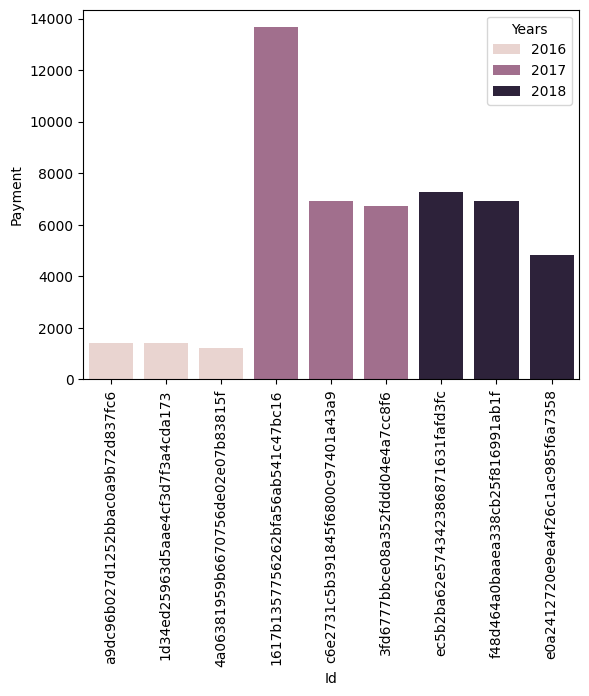

In [28]:
query = """Select years,customer_id,payment,d_rank from
(Select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group  by orders.order_purchase_timestamp,
orders.customer_id) as a where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Id","Payment","Rank"])
sns.barplot(x = "Id" , y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()